# Sommelier inteligente

## Visão geral e objetivos

A objetivo da aplicação é gerar um modelo e aplicação em aprendizado de máquina denominada Sommelier Inteligente que automaticamente reconheça um determinado tipo de vinho considerando os conjunto de dados no repositório: https://archive.ics.uci.edu/ml/datasets/wine

# Passo 1. Setup do projeto

In [99]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn 
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

print('Matplot version : {}'.format(matplotlib.__version__))
print('Numpy version : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

WINE_ROOT = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/'
WINE_URL  = WINE_ROOT + 'wine.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'wine.csv'
WINE_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', '', 'model')
DEPLOY_FILE = 'finalized_model.sav'
#DEPLOY_FILE = datetime.now().strftime("%Y%m%d_%H%M%S") + '_finalized_model.sav'


Matplot version : 3.3.2
Numpy version : 1.19.2
Pandas version : 1.1.3
Sklearn version : 0.23.2


#  Passo 2. Recuperação dos dados

In [100]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

In [101]:
download_data(WINE_URL, DATA_PATH, DATA_FILE)

In [102]:

def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['classe','alcool','acido_malico','cinza','alcalinidade_das_cinzas',
                                                       'magnesio','flavanoides_totais','flavanoides','fenois_nao_flavanoides',
                                                       'proantocianinas','intensidade_da_cor','Matiz','OD280_OD315','proline'])

In [103]:
wine_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3. Análise Exploratória de Dados

In [104]:
wine_data.head()

classe  alcool  acido_malico  cinza  alcalinidade_das_cinzas  magnesio  \
0       1   14.23          1.71   2.43                     15.6       127   
1       1   13.20          1.78   2.14                     11.2       100   
2       1   13.16          2.36   2.67                     18.6       101   
3       1   14.37          1.95   2.50                     16.8       113   
4       1   13.24          2.59   2.87                     21.0       118   

   flavanoides_totais  flavanoides  fenois_nao_flavanoides  proantocianinas  \
0                2.80         3.06                    0.28             2.29   
1                2.65         2.76                    0.26             1.28   
2                2.80         3.24                    0.30             2.81   
3                3.85         3.49                    0.24             2.18   
4                2.80         2.69                    0.39             1.82   

   intensidade_da_cor  Matiz  OD280_OD315  proline  
0                5.64   1.04         3.92     1065  
1                4.38   1.05         3.40     1050  
2                5.68   1.03         3.17     1185  
3                7.80   0.86         3.45     1480  
4                4.32   1.04         2.93      735

In [105]:
wine_data['classe'] = wine_data['classe'].astype(float)
wine_data['proline'] = wine_data['proline'].astype(float)
wine_data['magnesio'] = wine_data['magnesio'].astype(float)

In [106]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   classe                   178 non-null    float64
 1   alcool                   178 non-null    float64
 2   acido_malico             178 non-null    float64
 3   cinza                    178 non-null    float64
 4   alcalinidade_das_cinzas  178 non-null    float64
 5   magnesio                 178 non-null    float64
 6   flavanoides_totais       178 non-null    float64
 7   flavanoides              178 non-null    float64
 8   fenois_nao_flavanoides   178 non-null    float64
 9   proantocianinas          178 non-null    float64
 10  intensidade_da_cor       178 non-null    float64
 11  Matiz                    178 non-null    float64
 12  OD280_OD315              178 non-null    float64
 13  proline                  178 non-null    float64
dtypes: float64(14)
memory usag

In [107]:
wine_data.describe()

classe      alcool  acido_malico       cinza  \
count  178.000000  178.000000    178.000000  178.000000   
mean     1.938202   13.000618      2.336348    2.366517   
std      0.775035    0.811827      1.117146    0.274344   
min      1.000000   11.030000      0.740000    1.360000   
25%      1.000000   12.362500      1.602500    2.210000   
50%      2.000000   13.050000      1.865000    2.360000   
75%      3.000000   13.677500      3.082500    2.557500   
max      3.000000   14.830000      5.800000    3.230000   

       alcalinidade_das_cinzas    magnesio  flavanoides_totais  flavanoides  \
count               178.000000  178.000000          178.000000   178.000000   
mean                 19.494944   99.741573            2.295112     2.029270   
std                   3.339564   14.282484            0.625851     0.998859   
min                  10.600000   70.000000            0.980000     0.340000   
25%                  17.200000   88.000000            1.742500     1.205000   
50%                  19.500000   98.000000            2.355000     2.135000   
75%                  21.500000  107.000000            2.800000     2.875000   
max                  30.000000  162.000000            3.880000     5.080000   

       fenois_nao_flavanoides  proantocianinas  intensidade_da_cor  \
count              178.000000       178.000000          178.000000   
mean                 0.361854         1.590899            5.058090   
std                  0.124453         0.572359            2.318286   
min                  0.130000         0.410000            1.280000   
25%                  0.270000         1.250000            3.220000   
50%                  0.340000         1.555000            4.690000   
75%                  0.437500         1.950000            6.200000   
max                  0.660000         3.580000           13.000000   

            Matiz  OD280_OD315      proline  
count  178.000000   178.000000   178.000000  
mean     0.957449     2.611685   746.893258  
std      0.228572     0.709990   314.907474  
min      0.480000     1.270000   278.000000  
25%      0.782500     1.937500   500.500000  
50%      0.965000     2.780000   673.500000  
75%      1.120000     3.170000   985.000000  
max      1.710000     4.000000  1680.000000

# Correlação e distribuição

In [108]:
X = wine_data[['alcool','acido_malico','cinza','alcalinidade_das_cinzas',
               'magnesio','flavanoides_totais','flavanoides','fenois_nao_flavanoides',
               'intensidade_da_cor','Matiz','OD280_OD315','proline']]

y = wine_data['classe']

<AxesSubplot:xlabel='classe', ylabel='intensidade_da_cor'>

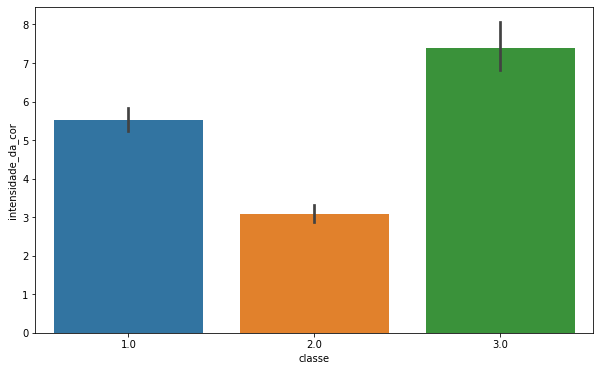

In [109]:
#Intensidade da cor é bem distinta entre as Classes 
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'classe', y = 'intensidade_da_cor', data = wine_data)

<AxesSubplot:xlabel='classe', ylabel='alcool'>

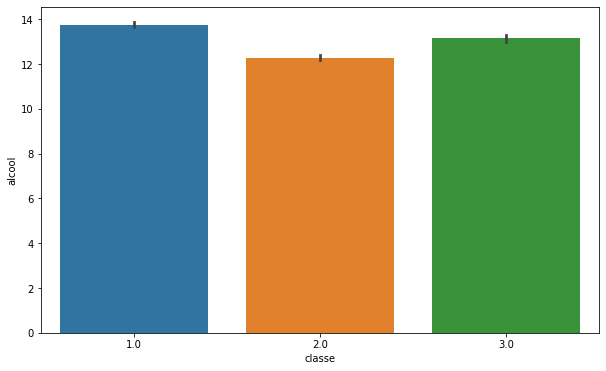

In [110]:
#Concentraçao alcoolica não é um grande diferencial entre as classes.
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'classe', y = 'alcool', data = wine_data)

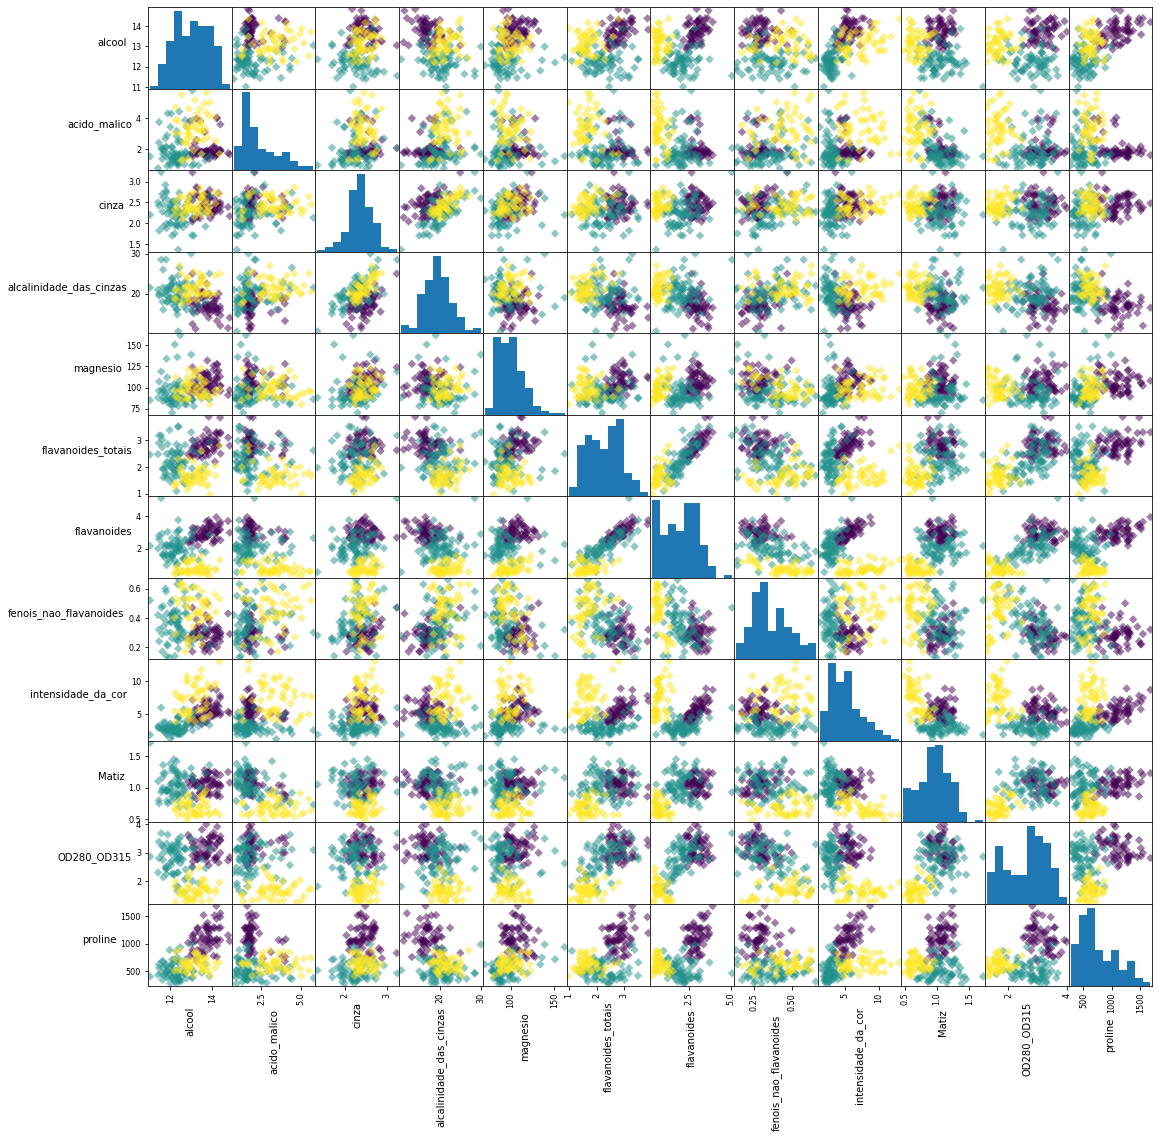

In [111]:
cores = y.astype('category').cat.codes
_ = pd.plotting.scatter_matrix(X, c=cores, figsize=[18, 18], marker='D')

for ax in _.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

# Passo 4: Treinamento do Modelo

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)

In [113]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy  = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i]  = knn.score(X_test, y_test)

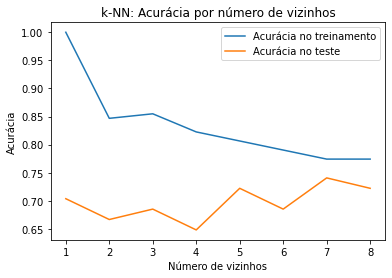

In [114]:
plt.title('k-NN: Acurácia por número de vizinhos')
plt.plot(neighbors, train_accuracy, label='Acurácia no treinamento')
plt.plot(neighbors, test_accuracy, label='Acurácia no teste')
plt.legend()
plt.xlabel('Número de vizinhos')
plt.ylabel('Acurácia')
plt.show()

In [115]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

# Passo 5: Testar o modelo

In [116]:
predicoes = model.predict(X_test)
print('Predições: {}'.format(predicoes))
[['1']][0]

Predições: [1. 2. 1. 1. 1. 1. 2. 3. 2. 3. 2. 3. 3. 2. 1. 3. 2. 1. 1. 3. 2. 1. 3. 3.
 3. 3. 1. 3. 1. 3. 3. 2. 3. 2. 3. 3. 3. 3. 3. 1. 3. 1. 1. 1. 1. 2. 2. 1.
 3. 3. 2. 2. 3. 1.]


['1']

In [117]:
acuracia = model.score(X_test, y_test)
print("Acurácia do model: {}".format(acuracia))

Acurácia do model: 0.7407407407407407


# Passo 6. Deploy do modelo

In [118]:
local_path = os.path.join(DEPLOY_PATH, DEPLOY_FILE)
joblib.dump(model, local_path)

['..\\model\\finalized_model.sav']